# Automatic Differentiation Implementation

In this notebook, we will implement **Forward Mode** and **Reverse Mode** from **Automatic Differentiation** using the operator overloading method in Python. The core idea is to define a custom `Variable` class that keeps track of both the value and its derivative and overloads arithmetic operations to propagate derivatives according to calculus rules.


# Forward Mode

## The `VariableForward` Class

The `VariableForward` class in forward mode automatic differentiation represents a value during computation along with its **tangent**, which is the derivative of the function with respect to that VariableForward.

It encapsulates two key components:
- **`primal`**: the actual numerical value of the VariableForward (used to evaluate the function normally)
- **`tangent`**: the value of the derivative of the output with respect to this VariableForward (used to track how a small change in the input affects the output)

In forward mode, we compute both the value and derivative **simultaneously** as we evaluate the function. This is particularly efficient when the number of inputs is small compared to the number of outputs.

### Operator Overloading

We override the standard arithmetic operations (`+`, `-`, `*`, `/`) to support automatic propagation of derivatives. Each operation not only computes the result of the operation but also applies the **chain rule** to update the tangent accordingly.

For instance, if `x` and `y` are `VariableForward` objects:
- `x * y` will compute:
  - `primal = x.primal * y.primal`
  - `tangent = x.tangent * y.primal + y.tangent * x.primal`

We also support operations between a `VariableForward` and a plain Python number, making it seamless to mix constants and variables in expressions.

### Elementary Functions

Functions like `sin`, `exp`, and `square` are defined specifically for `VariableForward` inputs. They compute both:
- the function value (e.g. `sin(x.primal)`)
- the derivative using the chain rule (e.g. `cos(x.primal) * x.tangent` for `sin(x)`)

This setup allows us to compute the derivative of any scalar function programmatically, just by initializing the input variables with appropriate tangent values (typically `1.0` for the VariableForward of interest and `0.0` for others).

Forward mode is ideal when you're interested in how a function changes with respect to **one** input at a time, such as computing directional derivatives or columns of the Jacobian matrix.


In [1]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
import math
import time
import csv
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [15]:
class VariableForward:
    def __init__(self, primal, tangent=0.0):
        self.primal = primal
        self.tangent = tangent

    def __add__(self, other):
        if isinstance(other, VariableForward):
            return VariableForward(self.primal + other.primal, self.tangent + other.tangent)
        else:
            return VariableForward(self.primal + other, self.tangent)

    def __sub__(self, other):
        if isinstance(other, VariableForward):
            return VariableForward(self.primal - other.primal, self.tangent - other.tangent)
        else:
            return VariableForward(self.primal - other, self.tangent)
    
    def __mul__(self, other):
        if isinstance(other, VariableForward):
            return VariableForward(
                self.primal * other.primal,
                self.tangent * other.primal + other.tangent * self.primal
            )
        else:
            return VariableForward(self.primal * other, self.tangent * other)

    def __truediv__(self, other):
        return VariableForward(
            self.primal / other.primal,
            (self.tangent * other.primal - self.primal * other.tangent) / (other.primal**2)
        )
    
    def __radd__(self, other):
        return self + other if isinstance(other, VariableForward) else VariableForward(self.primal + other, self.tangent)

    def __rmul__(self, other):
        return self * other if isinstance(other, VariableForward) else VariableForward(self.primal * other, self.tangent * other)


    def __repr__(self):
        return f"primal: {self.primal:.3f}, tangent: {self.tangent:.3f}"
        

def sin(x):
    return VariableForward(math.sin(x.primal), math.cos(x.primal) * x.tangent)

def exp(x):
    epx = math.exp(x.primal)
    return VariableForward(epx, epx * x.tangent)

def square(x):
    return VariableForward(x.primal**2, 2 * x.primal * x.tangent)

## Example 1: Automatic differentiation in forward mode

Let's calculate the partial derivatives of the function

$$f(x_1, x_2) = \left[\sin\left(\frac{x_1}{x_2}\right) + \frac{x_1}{x_2} - e^{x_2}\right] \cdot \left[\frac{x_1}{x_2} - e^{x_2}\right]$$

using forward mode, at the point $ (x_1, x_2) = (1.5, 0.5) $.



In [3]:
def f(x1, x2):
    return (sin(x1 / x2) + x1 / x2 - exp(x2)) * (x1 / x2 - exp(x2))

### Calculation of $ \frac{\partial f}{\partial x_1} $ at (1.5, 0.5)

In [4]:
x1_val = 1.5
x1_tan = 1.0
x2_val = 0.5
x2_tan = 0.0

x1 = VariableForward(x1_val, x1_tan)  # ∂x1/∂x1 = 1
x2 = VariableForward(x2_val, x2_tan)  # ∂x2/∂x1 = 0

y = f(x1, x2)
print(f"f({x1_val:.1f}, {x2_val:.1f}) = {y.primal:.3f}")
print(f"∂f/∂x1 = {y.tangent:.3f}")

f(1.5, 0.5) = 2.017
∂f/∂x1 = 3.012


### Calculation of $ \frac{\partial f}{\partial x_2} $ at (1.5, 0.5)

In [5]:
x1_val = 1.5
x1_tan = 0.0
x2_val = 0.5
x2_tan = 1.0

x1 = VariableForward(x1_val, x1_tan)  # ∂x1/∂x1 = 0
x2 = VariableForward(x2_val, x2_tan)  # ∂x2/∂x1 = 1

y = f(x1, x2)
print(f"f({x1_val:.1f}, {x2_val:.1f}) = {y.primal:.3f}")
print(f"∂f/∂x2 = {y.tangent:.3f}")


f(1.5, 0.5) = 2.017
∂f/∂x2 = -13.724


## Example 2: Automatic differentiation in forward mode

Let's calculate the Jacobian matrix of the function

$$
g(x_1, x_2, x_3, x_4) = (x_2 \sin(x_1) + x_2^2, 2 \, x_3x_4 + x_1) = (r_0, r_1)
$$

using forward mode, at the point $(x_1, x_2, x_3, x_4) = (1.5, 0.5, 2.0, 3.0)$.

In [6]:
def g(x1, x2, x3, x4):
    r0 = x2 * sin(x1) + square(x2)
    r1 = 2 * x3 * x4 + x1
    return [r0, r1]


In [7]:
def compute_jacobian(f, x_vals):
    n_inputs = len(x_vals)
    y_sample = f(*[VariableForward(val, 0.0) for val in x_vals])
    n_outputs = len(y_sample)
    
    jacobian = []

    for i in range(n_inputs):
        # Set all tangents to 0.0 except for the i-th VariableForward
        x_vars = [VariableForward(val, 1.0 if j == i else 0.0) for j, val in enumerate(x_vals)]
        y = f(*x_vars)
        jacobian.append([yi.tangent for yi in y])
    
    # Print primal output and the Jacobian in aligned format with square brackets
    print(f"g({', '.join(map(str, x_vals))}) =", [yi.primal for yi in y_sample])
    print("\nJ_g:")
    for row in list(map(list, zip(*jacobian))):
        print(f"[{', '.join(f'{val: .3f}' for val in row)}]")

    return jacobian


In [8]:
x_vals = [1.5, 0.5, 2.0, 3.0]
J = compute_jacobian(g, x_vals)

g(1.5, 0.5, 2.0, 3.0) = [0.7487474933020273, 13.5]

J_g:
[ 0.035,  1.997,  0.000,  0.000]
[ 1.000,  0.000,  6.000,  4.000]


## Example 3: Benchmarking Forward-Mode Automatic Differentiation

We are analyzing a vector-valued function defined as follows:

$$
y[j] = \sum_{i=0}^{n-1} (x[i] \cdot (j + 1)) \quad \text{for } j = 0 \text{ to } m-1
$$


So the output vector consists of scaled sums of all inputs, with each output scaled by its own index. 

We want to **measure and compare** the **execution time** needed to compute the full Jacobian of the function getting three distinct scenarios:

### 1. Varying Input Size (n)
- The number of outputs `m` is kept fixed (e.g., `m = 100`)
- The number of inputs `n` increases
- **Purpose:** To see how performance scales as input dimensionality increases

### 2. Varying Output Size (m)
- The number of inputs `n` is kept fixed (e.g., `n = 100`)
- The number of outputs `m` increases
- **Purpose:** To observe time changes as the number of output equations grows

### 3. Square Case (n = m)
- Both inputs and outputs are increased together
- **Purpose:** To evaluate the performance when the squared Jacobian is incremented

---

### What We Expect to See

- **Forward-mode automatic differentiation** scales **linearly with the number of inputs** (`n`) because it computes one directional derivative at a time.
- Increasing the number of **outputs** (`m`) will impact performance, but typically not as severely, since outputs are all computed in one forward pass.
- In the **square case** (`n = m`), we expect the time complexity to grow **quadratically**, due to the interplay of increasing both dimensions.

Running benchmarks for size=10...
  Vary n: 0.0120s, Vary m: 0.1051s, Square: 0.0041s
Running benchmarks for size=20...
  Vary n: 0.0398s, Vary m: 0.2010s, Square: 0.0129s
Running benchmarks for size=30...
  Vary n: 0.1851s, Vary m: 0.3179s, Square: 0.0320s
Running benchmarks for size=40...
  Vary n: 0.1722s, Vary m: 0.4299s, Square: 0.0682s
Running benchmarks for size=50...
  Vary n: 0.2735s, Vary m: 0.5618s, Square: 0.1388s
Running benchmarks for size=60...
  Vary n: 0.3973s, Vary m: 0.6606s, Square: 0.2563s
Running benchmarks for size=70...
  Vary n: 0.5767s, Vary m: 0.7591s, Square: 0.3853s
Running benchmarks for size=80...
  Vary n: 0.7058s, Vary m: 0.8331s, Square: 0.5334s
Running benchmarks for size=90...
  Vary n: 0.8545s, Vary m: 0.7275s, Square: 0.5601s
Running benchmarks for size=100...
  Vary n: 0.8013s, Vary m: 0.8668s, Square: 0.7976s
Running benchmarks for size=110...
  Vary n: 0.9745s, Vary m: 0.8708s, Square: 1.1091s
Running benchmarks for size=120...
  Vary n: 1.1963s

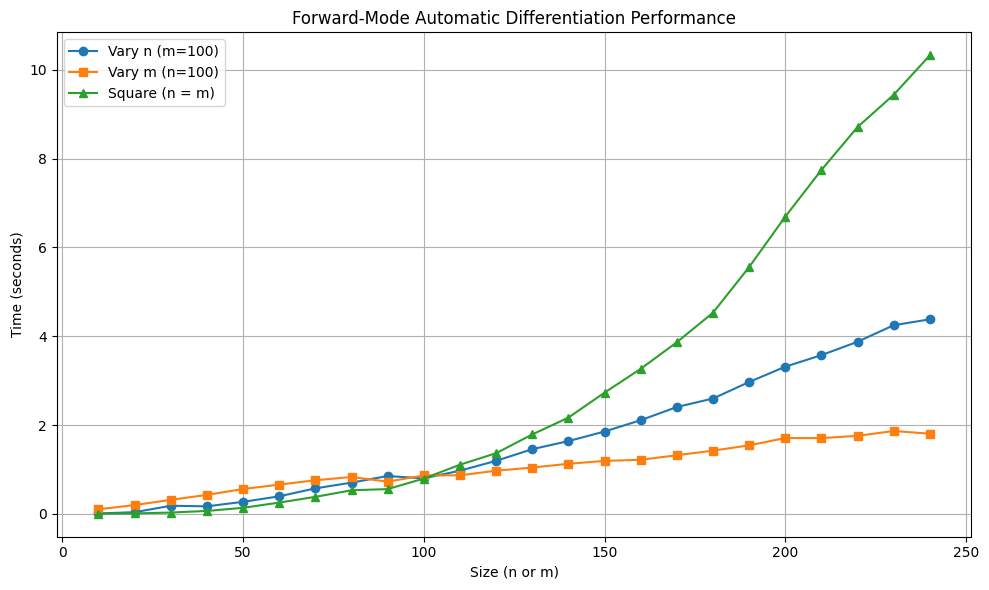

In [16]:
def vector_func(n, m):
    # Let's say x is length n, we return m outputs
    return [sum(xi * (j + 1) for xi in n) for j in range(m)]

def compute_jacobian_vector(f, x_vals, m):
    n_inputs = len(x_vals)    
    jacobian = []

    for i in range(n_inputs):
        # Set all tangents to 0.0 except for the i-th variable
        x_vars = [VariableForward(val, 1.0 if j == i else 0.0) for j, val in enumerate(x_vals)]
        y = f(x_vars, m)
        jacobian.append([yi.tangent for yi in y])

    return jacobian

# Wrapper for benchmarking
def compute_jacobian(n, m):
    x_vals = np.random.rand(n).tolist()  # Random input vector of size n
    start_time = time.time()
    jacobian = compute_jacobian_vector(vector_func, x_vals, m)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time, jacobian

# Benchmarking loop
sizes = list(range(10, 250, 10))  
fixed_m = 100
fixed_n = 100

times_vary_n_forward = []
times_vary_m_forward = []
times_square_forward = []

for i in sizes:
    print(f"Running benchmarks for size={i}...")

    # 1. Vary n, fix m
    t1, _ = compute_jacobian(i, fixed_m)
    times_vary_n_forward.append(t1)

    # 2. Vary m, fix n
    t2, _ = compute_jacobian(fixed_n, i)
    times_vary_m_forward.append(t2)

    # 3. Square case (n = m)
    t3, _ = compute_jacobian(i, i)
    times_square_forward.append(t3)

    print(f"  Vary n: {t1:.4f}s, Vary m: {t2:.4f}s, Square: {t3:.4f}s")

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(sizes, times_vary_n_forward, label=f"Vary n (m={fixed_m})", marker='o')
plt.plot(sizes, times_vary_m_forward, label=f"Vary m (n={fixed_n})", marker='s')
plt.plot(sizes, times_square_forward, label="Square (n = m)", marker='^')
plt.title("Forward-Mode Automatic Differentiation Performance")
plt.xlabel("Size (n or m)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

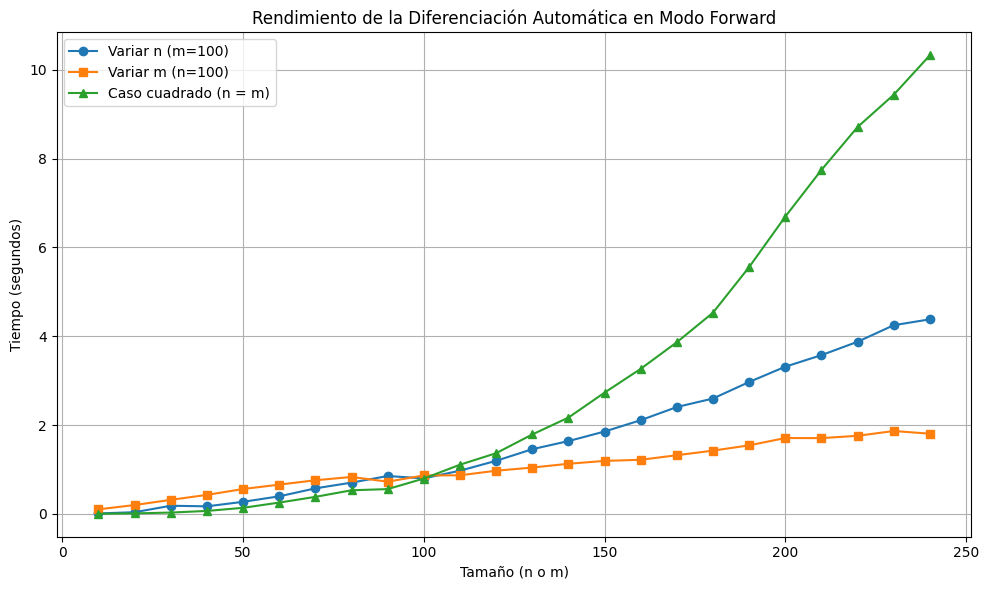

In [17]:
# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(sizes, times_vary_n_forward, label=f"Variar n (m={fixed_m})", marker='o')
plt.plot(sizes, times_vary_m_forward, label=f"Variar m (n={fixed_n})", marker='s')
plt.plot(sizes, times_square_forward, label="Caso cuadrado (n = m)", marker='^')
plt.title("Rendimiento de la Diferenciación Automática en Modo Forward")
plt.xlabel("Tamaño (n o m)")
plt.ylabel("Tiempo (segundos)")
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save pdf plot
plt.savefig("forward_example3.pdf", format='pdf')
plt.show()


## Example 4: Benchmarking Multilayer Perceptrons with Forward-Mode Automatic Differentiation

Multilayer Perceptrons (MLPs) are a fundamental type of **feedforward neural network** used for function approximation and classification tasks. They consist of multiple layers of neurons, where each layer transforms its inputs via **learnable weights**, **biases**, and **nonlinear activation functions**.

---

## Dataset and Notation

The model parameters are estimated using a **training set**:

$$
\mathcal{D} = (\mathbf{X}, \mathbf{Y}) = \{ (\mathbf{x}_n, \mathbf{y}_n) \}_{n=1}^N
$$

- $\mathbf{x}_n = (x_{n1}, x_{n2}, \dots, x_{nK}) \in \mathbb{R}^K$: Input vector of the $n$-th pattern  
- $K$: Input space dimensionality (number of features)  
- $\mathbf{y}_n \in \{0, 1\}^J$: Target class label using **1-of-$J$ encoding**  
  - That is, $y_{nj} = 1$ if $\mathbf{x}_n$ belongs to class $j$, and 0 otherwise  
- $J$: Number of classes  

The label matrix for all samples is denoted as:

$$
\mathbf{Y} = 
\begin{pmatrix}
\mathbf{y}_1^\top \\
\vdots \\
\mathbf{y}_N^\top
\end{pmatrix}
\in \{0, 1\}^{N \times J}
$$

The network defines a mapping:

$$
f: \mathbb{R}^{N \times K} \to \mathbb{R}^{N \times J}
$$

that computes a predicted output $\hat{\mathbf{Y}} = f(\mathbf{X})$ over the entire dataset.

---

## Network Architecture

We consider a **fully connected MLP** where each unit in a layer is connected to every unit in the next layer.

- $K$: Number of input neurons  
- $L$: Number of hidden neurons  
- $J$: Number of output neurons  

Other notations:
- $\hat{y}_{nj}$: Estimated output for class $j$ of sample $n$  
- $s_l^n$: Output of hidden neuron $l$ for sample $n$  
- $g_1(\cdot)$ and $g_2(\cdot)$: Activation functions for output and hidden layers  
- $w_{lj}$: Weight from hidden neuron $l$ to output neuron $j$  
- $t_{lk}$: Weight from input $k$ to hidden neuron $l$  

The forward pass for **each sample $n$ in batch** is:

- **Hidden layer**:
  $$
  s_{ln} = g_2\left( \sum_{k=1}^{K} t_{lk} x_{nk} \right)
  $$

- **Output layer**:
  $$
  \hat{y}_{nj} = g_1\left( \sum_{l=1}^{L} w_{lj} s_{ln} \right)
  $$

Let $\mathbf{t} \in \mathbb{R}^{L \times K}$ and $\mathbf{w} \in \mathbb{R}^{J \times L}$ be the trainable weights.

---

## Parameter Estimation with Automatic Differentiation

We define a scalar loss over the entire training set using **mean squared error**. We estimate the parameters $\mathbf{w}$ and $\mathbf{t}$ by minimizing the total loss function. This function is fully differentiable and serves as the target for automatic differentiation. Using the batch formulation ensures stable gradient computation and better benchmarks. The training process is **iterative**, indexed by $i = 1, \dots, I$, where $I$ is the total number of training iterations (or epochs).

At each iteration $i$, we evaluate the loss over the entire training set:

$$
E(\mathbf{w}, \mathbf{t})(i) = \frac{1}{2N} \sum_{n=1}^{N} \sum_{j=1}^{J} \left( y_{nj} - \hat{y}_{nj}(i) \right)^2
$$

where:
- $\hat{y}_{nj}(i)$ is the estimated output for class $j$ and pattern $n$ at iteration $i$

Rather than deriving each gradient expression manually, we use **automatic differentiation** to compute:

- The full gradient $\nabla_{\mathbf{w}} E \in \mathbb{R}^{J \times L}$
- The full gradient $\nabla_{\mathbf{t}} E \in \mathbb{R}^{L \times K}$

Then, the parameters are updated via a **gradient descent step**:

- **Output layer weights**:
  $$
  \Delta \mathbf{w}_{lj} = - \eta \frac{\partial E(\mathbf{w}, \mathbf{t})}{\partial \mathbf{w}_{lj}}
  $$

- **Hidden layer weights**:
  $$
  \Delta \mathbf{t}_{lk} = -\eta \frac{\partial E(\mathbf{w}, \mathbf{t})}{\partial \mathbf{t}_{lk}}
  $$

Where $\eta$ is the learning rate and the gradients are evaluated using an automatic differentiation library (e.g., JAX, PyTorch, TensorFlow).


In [7]:
def sigmoid_forward(v):
        val = 1 / (1 + math.exp(-v.primal))
        return VariableForward(val, val * (1 - val) * v.tangent)

def matvec_dot(A, x):
    return [sum(aij * xj for aij, xj in zip(ai, x)) for ai in A]

def apply_activation(v, fn):
    return [fn(vi) for vi in v]

def forward_single(x, t, w):
    s = apply_activation(matvec_dot(t, x), sigmoid_forward)
    y_hat = apply_activation(matvec_dot(w, s), sigmoid_forward)
    return y_hat

def mse_loss_single(y_hat, y_true):
    errors = [(y_truei - y_hati) for y_truei, y_hati in zip(y_true, y_hat)]
    squared = [e * e for e in errors]
    return sum(squared) * 0.5 

def compute_gradient(x, t, w, y_true, K, L, J):

    flat_weights = [w[j][l] for j in range(J) for l in range(L)] + [t[l][k] for l in range(L) for k in range(K)]

    gradient = []

    for i in range(len(flat_weights)):
        # Flatten weights
        weights_vector = [
            VariableForward(var.primal, 1.0 if j == i else 0.0)
            for j, var in enumerate(flat_weights)
        ]

        # Obtain w and t vectors
        new_w_vector = weights_vector[:J * L]
        new_t_vector = weights_vector[J * L:]

        # Reshape w and t matrices
        new_w = [new_w_vector[i * L:(i + 1) * L] for i in range(J)]
        new_t = [new_t_vector[i * K:(i + 1) * K] for i in range(L)]
        
        y_hat = forward_single(x, new_t, new_w)
        loss_val = mse_loss_single(y_hat, y_true)
        gradient.append(loss_val.tangent)

    return gradient

def train_forward_mode(X_data, Y_data, K, L, J, epochs, lr):
    N = len(X_data)
    t = [[VariableForward(np.random.randn(), 0.0) for _ in range(K)] for _ in range(L)]
    w = [[VariableForward(np.random.randn(), 0.0) for _ in range(L)] for _ in range(J)]
    losses = []
    grad_times = []

    for epoch in range(epochs):
        total_loss = VariableForward(0.0, 0.0)

        for n in range(N):
            x = [VariableForward(val) for val in X_data[n]]
            y_true = [VariableForward(val) for val in Y_data[n]]
            # 1. Forward pass to get loss value
            y_hat = forward_single(x, t, w)
            loss_val = mse_loss_single(y_hat, y_true).primal
            total_loss += loss_val / len(Y_data)


        start = time.perf_counter()
        grad = compute_gradient(x, t, w, y_true, K, L, J)
        # print(f"Gradient: {grad}")
        end = time.perf_counter()       
        grad_times.append(end - start)
              
        # 3. Update weights using the computed gradients
        for l in range(L):
            for k in range(K):
                index_t = J * L + l * K + k
                t[l][k].primal -= lr * grad[index_t]
        
        for j in range(J):
            for l in range(L):
                index_w = j * L + l
                w[j][l].primal -= lr * grad[index_w]
        

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.primal:.4f}, Gradient Time: {end - start:.6f}s")
        losses.append(total_loss.primal)

    return t, w, losses, grad_times

def predict_forward(x, t, w):
    x_wrapped = [VariableForward(val, 0.0) for val in x]
    y_hat = forward_single(x_wrapped, t, w)
    return [y.primal for y in y_hat]

def classify(pred, threshold=0.5):
    return int(pred >= threshold)

# ---------- K-Fold Training ----------
def train_kfold_forward(X, Y, K, L, J, epochs, lr, n_splits, is_classification=True):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_losses = []
    fold_losses = []
    forward_times  = []
    fold = 0

    for train_idx, val_idx in kf.split(X):
        fold += 1
        print(f"\n--- Fold {fold} ---")
        X_train = [X[i] for i in train_idx]
        Y_train = [Y[i] for i in train_idx]
        X_val = [X[i] for i in val_idx]
        Y_val = [Y[i] for i in val_idx]

        t, w, losses, grad_times = train_forward_mode(X_train, Y_train, K, L, J, epochs, lr)
        fold_losses.append(losses)
        forward_times .append(grad_times)

        total_val_loss = 0.0
        correct = 0
        for x, y in zip(X_val, Y_val):
            pred = predict_forward(x, t, w)[0]
            if is_classification:
                correct += int(classify(pred) == int(y[0]))
            else:
                total_val_loss += 0.5 * (pred - y[0]) ** 2

        if is_classification:
            acc = correct / len(X_val)
            print(f"Validation Accuracy: {acc:.4f}")
            all_losses.append(1 - acc)
        else:
            mse = total_val_loss / len(X_val)
            print(f"Validation MSE: {mse:.4f}")
            all_losses.append(mse)

    print("\n--- K-Fold Summary ---")
    avg_metric = sum(all_losses) / len(all_losses)
    if is_classification:
        print(f"Avg Classification Error: {avg_metric:.4f}")
    else:
        print(f"Avg MSE: {avg_metric:.4f}")

    # Compute average backward time per epoch across folds
    num_epochs = len(forward_times [0])
    avg_forward_times = [
        sum(fold_times[epoch] for fold_times in forward_times ) / len(forward_times )
        for epoch in range(num_epochs)
    ]

    return fold_losses, avg_forward_times



--- Fold 1 ---
Epoch 0, Loss: 0.1690, Gradient Time: 0.002568s
Epoch 10, Loss: 0.1634, Gradient Time: 0.001095s
Epoch 20, Loss: 0.1582, Gradient Time: 0.001078s
Epoch 30, Loss: 0.1533, Gradient Time: 0.001037s
Epoch 40, Loss: 0.1488, Gradient Time: 0.001053s
Epoch 50, Loss: 0.1445, Gradient Time: 0.001077s
Epoch 60, Loss: 0.1405, Gradient Time: 0.001044s
Epoch 70, Loss: 0.1368, Gradient Time: 0.001128s
Epoch 80, Loss: 0.1334, Gradient Time: 0.001056s
Epoch 90, Loss: 0.1302, Gradient Time: 0.001039s
Epoch 100, Loss: 0.1272, Gradient Time: 0.001072s
Epoch 110, Loss: 0.1245, Gradient Time: 0.001080s
Epoch 120, Loss: 0.1219, Gradient Time: 0.001045s
Epoch 130, Loss: 0.1196, Gradient Time: 0.001071s
Epoch 140, Loss: 0.1174, Gradient Time: 0.001049s
Epoch 150, Loss: 0.1153, Gradient Time: 0.001051s
Epoch 160, Loss: 0.1134, Gradient Time: 0.001074s
Epoch 170, Loss: 0.1116, Gradient Time: 0.001061s
Epoch 180, Loss: 0.1100, Gradient Time: 0.002035s
Epoch 190, Loss: 0.1085, Gradient Time: 0.001

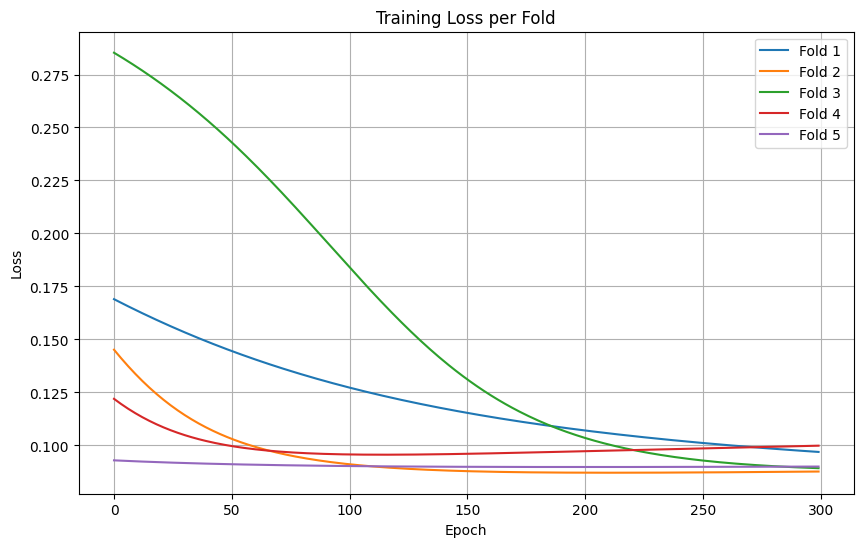

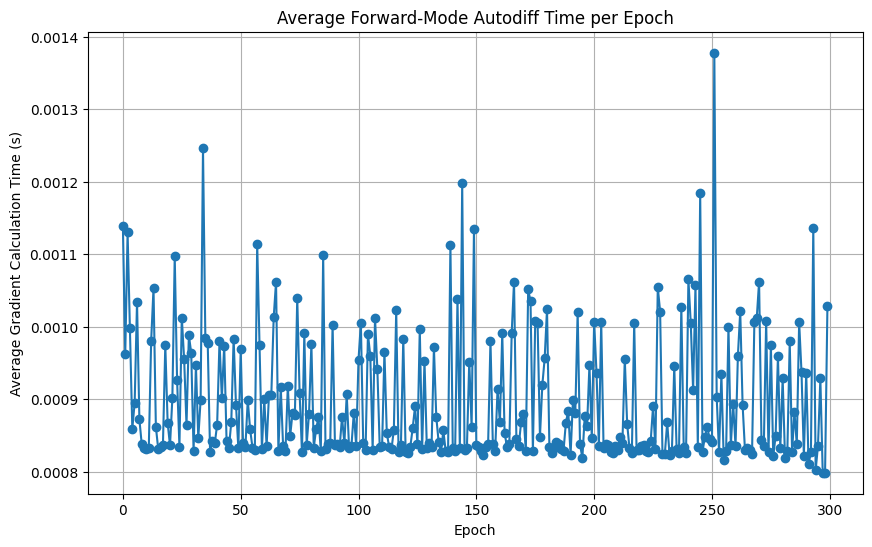

In [19]:
def load_txt_dataset(filepath, normalize=True):
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        data = [[float(val.strip()) for val in row] for row in reader]

    X = [row[:-1] for row in data]
    Y = [[row[-1]] for row in data]  # Empaquetado como lista para compatibilidad

    if normalize:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

    return X, Y

X_class, Y_class = load_txt_dataset("T_Blood_Transfusion.txt")
fold_losses_forward_ex1, avg_forward_times_ex1 = train_kfold_forward(X_class, Y_class, K=len(X_class[0]), L=4, J=len(Y_class[0]), epochs=300, lr=0.1, n_splits=5, is_classification=True)

plt.figure(figsize=(10, 6))
for i, losses in enumerate(fold_losses_forward_ex1):
    plt.plot(losses, label=f"Fold {i + 1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Fold")
plt.legend()
plt.grid(True)
plt.show()

# Plot average backward time per epoch
plt.figure(figsize=(10, 6))
plt.plot(avg_forward_times_ex1, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Gradient Calculation Time (s)")
plt.title("Average Forward-Mode Autodiff Time per Epoch")
plt.grid(True)
plt.show()

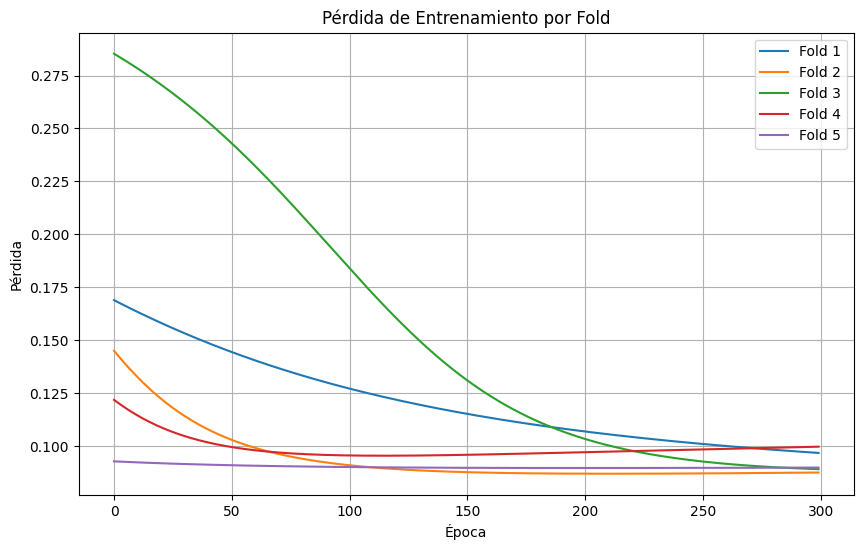

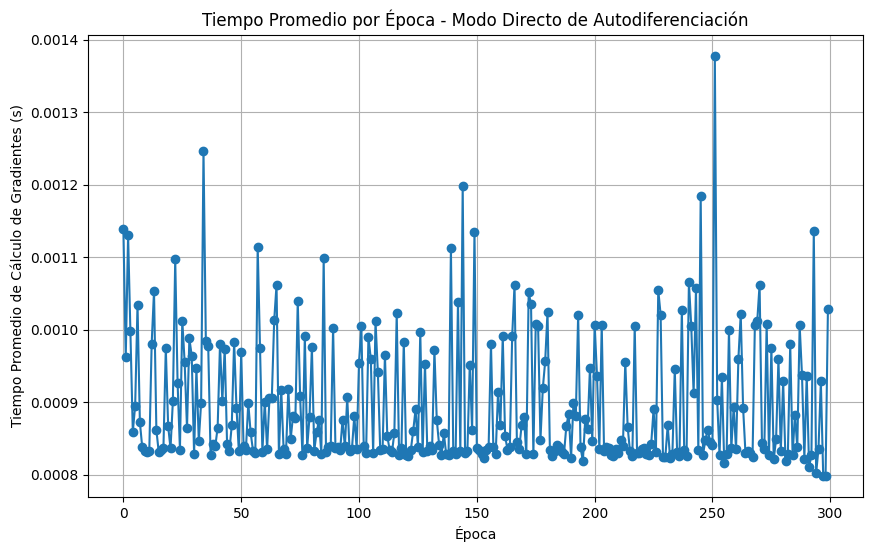

In [72]:
# Gráfico de pérdidas de entrenamiento por fold
plt.figure(figsize=(10, 6))
for i, perdidas in enumerate(fold_losses_forward_ex1):
    plt.plot(perdidas, label=f"Fold {i + 1}")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida de Entrenamiento por Fold")
plt.legend()
plt.grid(True)
plt.savefig("forward_example4_11.pdf", format='pdf')
plt.show()

# Gráfico del tiempo promedio por época
plt.figure(figsize=(10, 6))
plt.plot(avg_forward_times_ex1, marker='o')
plt.xlabel("Época")
plt.ylabel("Tiempo Promedio de Cálculo de Gradientes (s)")
plt.title("Tiempo Promedio por Época - Modo Directo de Autodiferenciación")
plt.grid(True)
plt.savefig("forward_example4_12.pdf", format='pdf')
plt.show()



--- Fold 1 ---
Epoch 0, Loss: 0.1627, Gradient Time: 1.415574s
Epoch 10, Loss: 0.1405, Gradient Time: 1.317821s
Epoch 20, Loss: 0.1414, Gradient Time: 1.743526s
Epoch 30, Loss: 0.1469, Gradient Time: 1.134747s
Epoch 40, Loss: 0.1516, Gradient Time: 1.117181s
Epoch 50, Loss: 0.1552, Gradient Time: 1.267339s
Epoch 60, Loss: 0.1580, Gradient Time: 1.168035s
Epoch 70, Loss: 0.1602, Gradient Time: 1.268382s
Epoch 80, Loss: 0.1620, Gradient Time: 1.127707s
Epoch 90, Loss: 0.1634, Gradient Time: 1.120563s
Validation Accuracy: 0.6228

--- Fold 2 ---
Epoch 0, Loss: 0.1210, Gradient Time: 1.149150s
Epoch 10, Loss: 0.1226, Gradient Time: 0.994979s
Epoch 20, Loss: 0.1441, Gradient Time: 1.007899s
Epoch 30, Loss: 0.1619, Gradient Time: 1.012606s
Epoch 40, Loss: 0.1750, Gradient Time: 1.010739s
Epoch 50, Loss: 0.1850, Gradient Time: 1.332347s
Epoch 60, Loss: 0.1928, Gradient Time: 1.078658s
Epoch 70, Loss: 0.1991, Gradient Time: 1.003838s
Epoch 80, Loss: 0.2044, Gradient Time: 1.027681s
Epoch 90, L

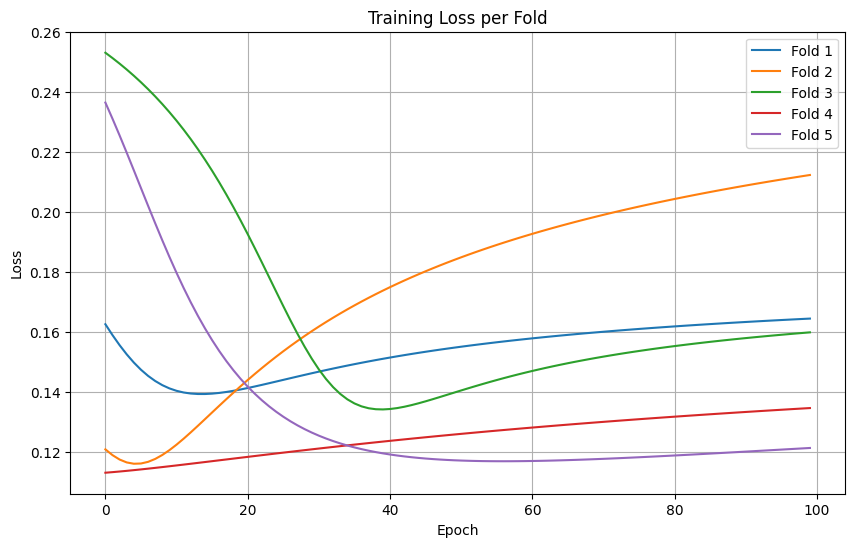

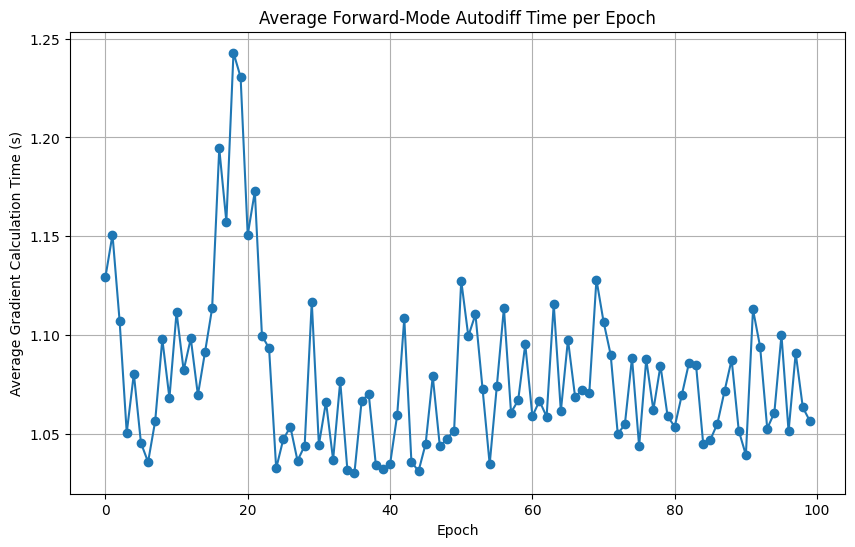

In [11]:
def load_breast_cancer_csv(path):
    X = []
    Y = []

    with open(path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            # Diagnosis is in column 1, features from column 2 onwards
            diagnosis = row[1]
            y = [1.0 if diagnosis == 'B' else 0.0]
            x = list(map(float, row[2:]))  # Skip id and diagnosis
            X.append(x)
            Y.append(y)

    # Normalize X using MinMax scaling
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X).tolist()

    return X, Y

X_data, Y_data = load_breast_cancer_csv("breast_cancer_data.csv")
fold_losses_forward_ex2, avg_forward_times_ex2 = train_kfold_forward(X_data, Y_data, K=len(X_data[0]), L=20, J=len(Y_data[0]), epochs=100, lr=0.1, n_splits=5, is_classification=True)

plt.figure(figsize=(10, 6))
for i, losses in enumerate(fold_losses_forward_ex2):
    plt.plot(losses, label=f"Fold {i + 1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Fold")
plt.legend()
plt.grid(True)
plt.show()

# Plot average backward time per epoch
plt.figure(figsize=(10, 6))
plt.plot(avg_forward_times_ex2, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Gradient Calculation Time (s)")
plt.title("Average Forward-Mode Autodiff Time per Epoch")
plt.grid(True)
plt.show()

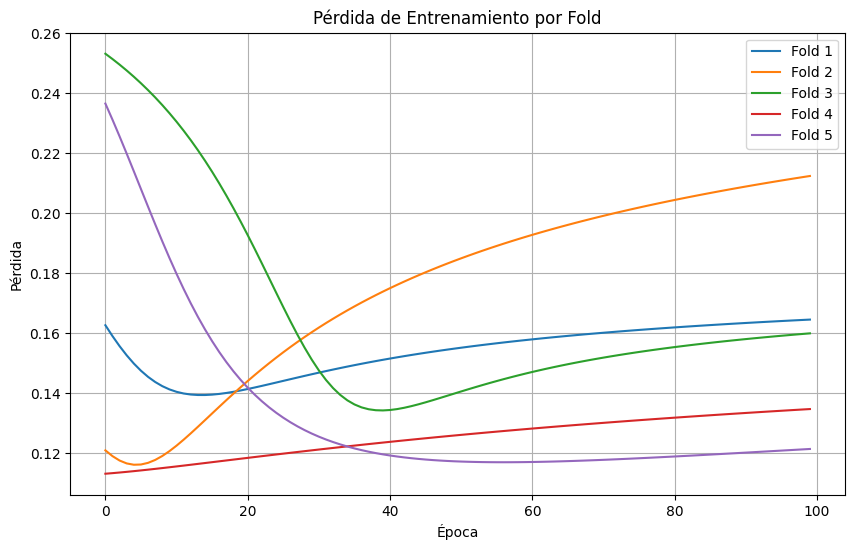

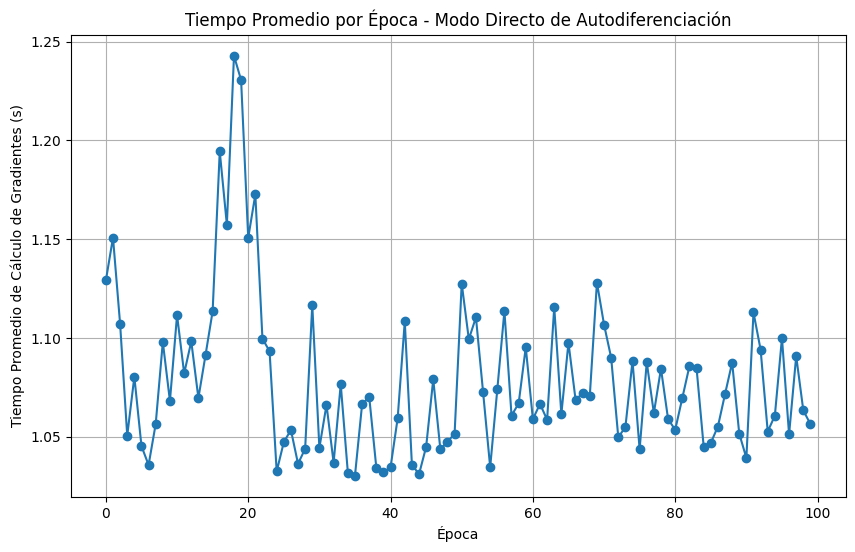

In [12]:
plt.figure(figsize=(10, 6))
for i, perdidas in enumerate(fold_losses_forward_ex2):
    plt.plot(perdidas, label=f"Fold {i + 1}")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida de Entrenamiento por Fold")
plt.legend()
plt.grid(True)
plt.savefig("forward_example4_21.pdf", format='pdf')
plt.show()

# Gráfico del tiempo promedio por época
plt.figure(figsize=(10, 6))
plt.plot(avg_forward_times_ex2, marker='o')
plt.xlabel("Época")
plt.ylabel("Tiempo Promedio de Cálculo de Gradientes (s)")
plt.title("Tiempo Promedio por Época - Modo Directo de Autodiferenciación")
plt.grid(True)
plt.savefig("forward_example4_22.pdf", format='pdf')
plt.show()


# Reverse Mode

## The `VariableReverse` Class

The `VariableReverse` class in reverse mode automatic differentiation represents a value used during computation and its corresponding **adjoint**, which holds the derivative of a final output with respect to that value.

It encapsulates two key attributes:
- **`primal`**: the actual value of the variable (used during function evaluation)
- **`adjoint`**: the accumulated gradient (derivative of the final result with respect to this variable)

In reverse mode, we evaluate the function **forward** (to compute all intermediate values), and then initiate a **reverse pass** (by calling `.backward()`) from the output back through the computation graph, accumulating derivatives into the `adjoint` of each variable.

Each arithmetic operation constructs a new `VariableReverse` and assigns it a custom `backward()` function, which:
1. Accumulates the incoming gradient into the result variable.
2. Computes the local partial derivatives.
3. Propagates those gradients to the operand variables using their `backward()` methods.

We also define reverse-mode implementations for elementary functions like `sin`, `exp`, and `square`, and include Python operator overloads so expressions like `2 * x` or `x + 3.0` work seamlessly.

This setup allows us to compute gradients of scalar outputs with respect to any number of inputs automatically, just by calling `.backward(1.0)` on the final result.


In [18]:
class VariableReverse:
    def __init__(self, primal, parents=None, grad_fn=None):
        self.primal = primal
        self.adjoint = 0.0
        self.parents = parents if parents is not None else []
        self.grad_fn = grad_fn  # function to propagate adjoint

    def backward(self, adjoint=1.0):
        self.adjoint += adjoint
        stack = [(self, adjoint)]  # Start with self and given adjoint

        while stack:
            var, adjoint = stack.pop()
            var.adjoint += adjoint
            if var.grad_fn is not None:
                grads = var.grad_fn(adjoint)
                for parent, grad in zip(var.parents, grads):
                    stack.append((parent, grad))  # Push onto stack

    def __add__(self, other):
        if not isinstance(other, VariableReverse):
            other = VariableReverse(other)
        out = VariableReverse(self.primal + other.primal, parents=[self, other],
                       grad_fn=lambda adjoint: [adjoint, adjoint])
        return out

    def __sub__(self, other):
        if not isinstance(other, VariableReverse):
            other = VariableReverse(other)
        out = VariableReverse(self.primal - other.primal, parents=[self, other],
                       grad_fn=lambda adjoint: [adjoint, -adjoint])
        return out

    def __mul__(self, other):
        if not isinstance(other, VariableReverse):
            other = VariableReverse(other)
        out = VariableReverse(self.primal * other.primal, parents=[self, other],
                       grad_fn=lambda adjoint: [adjoint * other.primal, adjoint * self.primal])
        return out

    def __truediv__(self, other):
        if not isinstance(other, VariableReverse):
            other = VariableReverse(other)
        out = VariableReverse(self.primal / other.primal, parents=[self, other],
                       grad_fn=lambda adjoint: [adjoint * (1.0 / other.primal),
                                                adjoint * (-self.primal / (other.primal ** 2))])
        return out

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return VariableReverse(other) - self

    def __rmul__(self, other):
        return self * other

    def __rtruediv__(self, other):
        return VariableReverse(other) / self

    def __repr__(self):
        return f"primal: {self.primal:.4f}, adjoint: {self.adjoint:.4f}"

def sin(var):
    out = VariableReverse(math.sin(var.primal), parents=[var],
                   grad_fn=lambda adjoint: [adjoint * math.cos(var.primal)])
    return out

def exp(var):
    out = VariableReverse(math.exp(var.primal))
    out.parents = [var]
    out.grad_fn = lambda adjoint: [adjoint * out.primal]
    return out

def square(var):
    out = VariableReverse(var.primal**2, parents=[var],
                   grad_fn=lambda adjoint: [adjoint * 2 * var.primal])
    return out

## Example 1: Automatic differentiation in reverse mode

Let's calculate the derivative of the function

$$
f(x_1, x_2) = \left[\sin\left(\frac{x_1}{x_2}\right) + \frac{x_1}{x_2} - e^{x_2}\right] \cdot \left[\frac{x_1}{x_2} - e^{x_2}\right]
$$

using forward mode, at the point $ (x_1, x_2) = (1.5, 0.5) $ first with respect to $ x_1 $, and then with respect to $ x_2 $.



In [49]:
def f(x1, x2):
    return (sin(x1 / x2) + x1 / x2 - exp(x2)) * (x1 / x2 - exp(x2))

In [50]:
x1 = VariableReverse(1.5)
x2 = VariableReverse(0.5)

y = f(x1, x2)
y.backward(1.0)

print(f"f({x1.primal:.1f}, {x2.primal:.1f}) = {y.primal:.3f}")
print(f"∂y/∂x1 = {x1.adjoint}")
print(f"∂y/∂x2 = {x2.adjoint}")


f(1.5, 0.5) = 2.017
∂y/∂x1 = 3.011843327673907
∂y/∂x2 = -13.723961509314078


## Example 2: Automatic differentiation in reverse mode

Let's calculate the derivative of the function

$$
g(x_1, x_2, x_3, x_4) = (x_2 \sin(x_1) + x_2^2, 2 \, x_3x_4 + x_1) = (r_0, r_1)
$$

using reverse mode, at the point $(x_1, x_2, x_3, x_4) = (1.5, 0.5, 2.0, 3.0)$. This example will focus on getting the Jacobian matrix.

In [51]:
def g(x1, x2, x3, x4):
    r0 = x2 * sin(x1) + square(x2)
    r1 = 2 * x3 * x4 + x1
    return [r0, r1]

In [52]:
def compute_jacobian_reverse(f, x_vals):
    n_inputs = len(x_vals)

    # Wrap raw inputs as Variables (fresh copies for each reverse pass)
    def make_vars():
        return [VariableReverse(val) for val in x_vals]

    # Forward pass to get outputs and output count
    vars = make_vars()
    outputs = f(*vars)
    n_outputs = len(outputs)

    jacobian = []

    for i in range(n_outputs):
        # Reset adjoints (fresh inputs and outputs every time)
        vars = make_vars()
        outputs = f(*vars)

        # Start reverse pass for output i
        outputs[i].backward(1.0)

        # Collect ∂output_i/∂xj (j = 0 to n_inputs-1)
        jacobian.append([var.adjoint for var in vars])

    # Print formatted Jacobian
    print(f"g({', '.join(map(str, x_vals))}) =", [y.primal for y in outputs])
    print("\nJ_g:")
    for row in jacobian:
        print(f"[{', '.join(f'{val: .3f}' for val in row)}]")

    return jacobian

In [53]:
x_vals = [1.5, 0.5, 2.0, 3.0]
J = compute_jacobian_reverse(g, x_vals)

g(1.5, 0.5, 2.0, 3.0) = [0.7487474933020273, 13.5]

J_g:
[ 0.035,  1.997,  0.000,  0.000]
[ 1.000,  0.000,  6.000,  4.000]


## Example 3: Benchmarking Reverse-Mode Automatic Differentiation

We are analyzing a vector-valued function defined as follows:

$$
y[j] = \sum_{i=0}^{n-1} (x[i] \cdot (j + 1)) \quad \text{for } j = 0 \text{ to } m-1
$$


So the output vector consists of scaled sums of all inputs, with each output scaled by its own index. 

We want to **measure and compare** the **execution time** needed to compute the full Jacobian of the function getting three distinct scenarios:

### 1. Varying Input Size (n)
- The number of outputs `m` is kept fixed (e.g., `m = 100`)
- The number of inputs `n` increases
- **Purpose:** To see how performance scales as input dimensionality increases

### 2. Varying Output Size (m)
- The number of inputs `n` is kept fixed (e.g., `n = 100`)
- The number of outputs `m` increases
- **Purpose:** To observe time changes as the number of output equations grows

### 3. Square Case (n = m)
- Both inputs and outputs are increased together
- **Purpose:** To evaluate the performance when the squared Jacobian is incremented

---

### What We Expect to See

- **Reverse-mode automatic differentiation** scales **linearly with the number of inputs** (`n`) because it computes one directional derivative at a time.
- Increasing the number of **outputs** (`m`) will impact performance, but typically not as severely, since outputs are all computed in one forward pass.
- In the **square case** (`n = m`), we expect the time complexity to grow **quadratically**, due to the interplay of increasing both dimensions.

size= 10, vary n: 1.7306s, vary m: 0.1869s, square: 0.0000s
size= 20, vary n: 3.0309s, vary m: 0.5537s, square: 0.0956s
size= 30, vary n: 5.0093s, vary m: 1.3770s, square: 0.3803s
size= 40, vary n: 7.5526s, vary m: 2.7895s, square: 0.8502s
size= 50, vary n: 9.3015s, vary m: 4.7442s, square: 2.0627s
size= 60, vary n: 11.7931s, vary m: 7.1489s, square: 3.8089s
size= 70, vary n: 13.1006s, vary m: 9.1367s, square: 6.2322s
size= 80, vary n: 16.2860s, vary m: 12.8464s, square: 9.9768s
size= 90, vary n: 18.7650s, vary m: 16.5739s, square: 15.4266s
size=100, vary n: 20.5552s, vary m: 20.9437s, square: 22.3810s
size=110, vary n: 23.9544s, vary m: 26.6242s, square: 29.2641s
size=120, vary n: 25.3343s, vary m: 30.8804s, square: 35.3278s
size=130, vary n: 26.8089s, vary m: 36.3004s, square: 43.5306s
size=140, vary n: 28.4600s, vary m: 40.1473s, square: 51.5441s
size=150, vary n: 28.9043s, vary m: 45.3669s, square: 61.2417s
size=160, vary n: 32.2167s, vary m: 53.2004s, square: 75.3802s
size=170, va

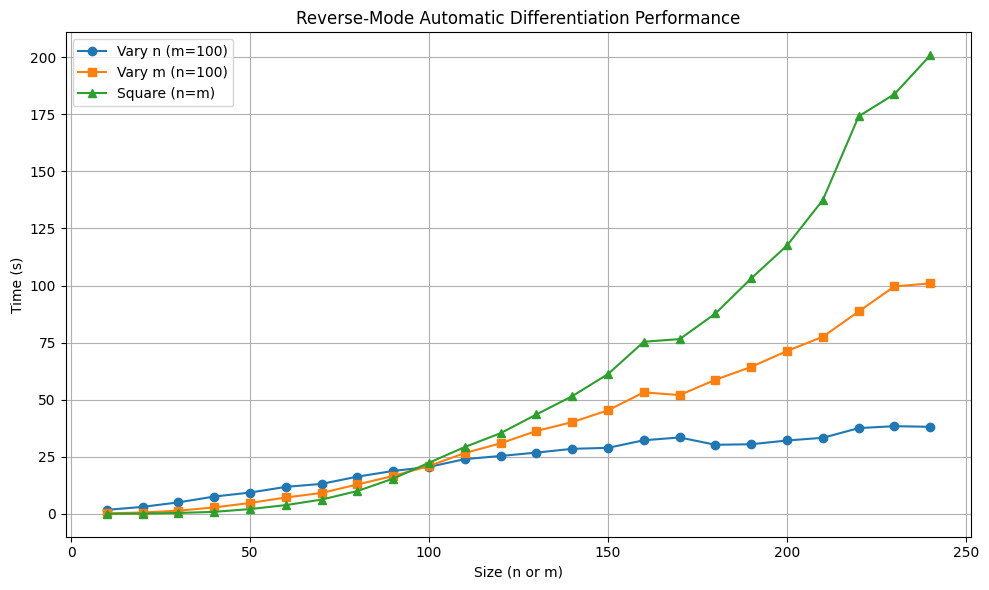

In [19]:
def vector_func(x_vars, m):
    n = len(x_vars)
    return [sum(x_vars[i] * (j+1) for i in range(n)) for j in range(m)]

def compute_jacobian_reverse(f, x_vals, m):
    n = len(x_vals)
    J = []
    for j in range(m):
        inputs = [VariableReverse(v) for v in x_vals]
        y = f(inputs, m)
        # backward only in the j-th output
        y[j].backward(1.0)
        J.append([v.adjoint for v in inputs])
    return J

def compute_jacobian(n, m):
    x_vals = np.random.rand(n).tolist()
    t0 = time.time()
    J = compute_jacobian_reverse(vector_func, x_vals, m)
    elapsed = time.time() - t0
    return elapsed, J

sizes = list(range(10, 250, 10))
fixed_m, fixed_n = 100, 100

times_vary_n_reverse = []
times_vary_m_reverse = []
times_square_reverse = []
for s in sizes:
    t1, _ = compute_jacobian(s, fixed_m)  # vary n
    t2, _ = compute_jacobian(fixed_n, s)  # vary m
    t3, _ = compute_jacobian(s, s)        # square
    times_vary_n_reverse.append(t1)
    times_vary_m_reverse.append(t2)
    times_square_reverse.append(t3)
    print(f"size={s:3d}, vary n: {t1:.4f}s, vary m: {t2:.4f}s, square: {t3:.4f}s")

# Plot results
plt.figure(figsize=(10,6))
plt.plot(sizes, times_vary_n_reverse, marker='o', label=f"Vary n (m={fixed_m})")
plt.plot(sizes, times_vary_m_reverse, marker='s', label=f"Vary m (n={fixed_n})")
plt.plot(sizes, times_square_reverse, marker='^', label="Square (n=m)")
plt.xlabel("Size (n or m)")
plt.ylabel("Time (s)")
plt.title("Reverse-Mode Automatic Differentiation Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

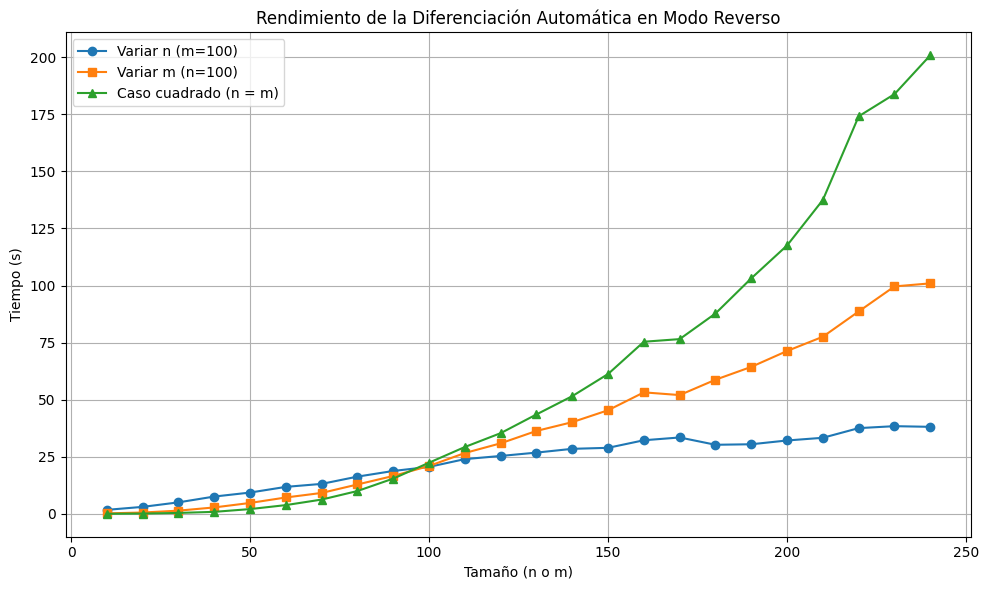

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, times_vary_n_reverse, marker='o', label=f"Variar n (m={fixed_m})")
plt.plot(sizes, times_vary_m_reverse, marker='s', label=f"Variar m (n={fixed_n})")
plt.plot(sizes, times_square_reverse, marker='^', label="Caso cuadrado (n = m)")
plt.xlabel("Tamaño (n o m)")
plt.ylabel("Tiempo (s)")
plt.title("Rendimiento de la Diferenciación Automática en Modo Reverso")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reverse_example3.pdf", format='pdf')
plt.show()

## Example 4: Benchmarking Multilayer Perceptrons with Reverse-Mode Automatic Differentiation

In this section, we repeat the multilayer perceptron (MLP) experiment, but this time we utilize **reverse-mode automatic differentiation** for computing gradients.

While the **network architecture**, **dataset**, and **loss formulation** remain identical to Example 4, the key difference lies in how gradients are computed. Reverse-mode is particularly well-suited for functions with **many inputs and few outputs**, such as scalar loss functions common in neural network training. Unlike forward-mode, which propagates derivatives **from inputs to outputs**, reverse-mode AD computes gradients **from outputs back to inputs**, making it highly efficient for computing gradients of scalar-valued functions with respect to a **large number of parameters**.

---

## Benchmarking Setup

We benchmark reverse-mode AD in the same MLP setting by measuring:

- **Loss convergence per fold** across training epochs (e.g., using k-fold cross-validation)
- **Average gradient computation time per epoch** using reverse-mode differentiation

These benchmarks help assess the **practical runtime performance** of reverse-mode AD compared to forward-mode in high-dimensional models.

In [3]:
def sigmoid_reverse(x):
    sig_val = 1 / (1 + math.exp(-x.primal))
    return VariableReverse(sig_val, parents=[x],
        grad_fn=lambda adjoint: [adjoint * sig_val * (1 - sig_val)])

def matvec_dot(A, x):
    return [sum(aij * xj for aij, xj in zip(ai, x)) for ai in A]

def apply_activation(v, fn):
    return [fn(vi) for vi in v]

def forward_single(x, t, w):
    s = apply_activation(matvec_dot(t, x), sigmoid_reverse)
    y_hat = apply_activation(matvec_dot(w, s), sigmoid_reverse)
    return y_hat

def mse_loss_single(y_hat, y_true):
    errors = [(y_truei - y_hati) for y_truei, y_hati in zip(y_true, y_hat)]
    squared = [e * e for e in errors]
    return sum(squared) * 0.5 

def update_weights(weights, learning_rate):
    for row in weights:
        for w in row:
            w.primal -= learning_rate * w.adjoint
            w.adjoint = 0.0

def train_reverse(X_data, Y_data, K, L, J, epochs, lr):
    N = len(X_data)
    t = [[VariableReverse(np.random.randn()) for _ in range(K)] for _ in range(L)]
    w = [[VariableReverse(np.random.randn()) for _ in range(L)] for _ in range(J)]
    total_losses = []
    
    backward_times = []

    for epoch in range(epochs):
        total_loss = VariableReverse(0.0)
        losses = []

        backward_time = 0.0
        for row in t + w:
            for param in row:
                param.adjoint = 0.0

        for n in range(N):
            x = [VariableReverse(val) for val in X_data[n]]
            y_true = [VariableReverse(val) for val in Y_data[n]]
            y_hat = forward_single(x, t, w)
            loss = mse_loss_single(y_hat, y_true)
            losses.append(loss)

        for l in losses:
            total_loss += l / N

        # 2. Batch backward pass
        start = time.perf_counter()
        total_loss.backward(1.0)
        end = time.perf_counter()
        backward_time = end - start

        update_weights(t, lr)
        update_weights(w, lr)


        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.primal:.4f}, Backward Time: {backward_time:.6f}s")

        total_losses.append(total_loss.primal)
        backward_times.append(backward_time)

    return t, w, total_losses, backward_times

def predict_reverse(x, t, w):
    x_wrapped = [VariableReverse(val) for val in x]
    y_hat = forward_single(x_wrapped, t, w)
    return [y.primal for y in y_hat]

def classify(pred, threshold=0.5):
    return int(pred >= threshold)

# ---------- K-Fold Training ----------
def train_kfold_reverse(X, Y, K, L, J, epochs, lr, n_splits, is_classification=True):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_losses = []
    fold_losses = []
    all_backward_times = []
    fold = 0

    for train_idx, val_idx in kf.split(X):
        fold += 1
        print(f"\n--- Fold {fold} ---")
        X_train = [X[i] for i in train_idx]
        Y_train = [Y[i] for i in train_idx]
        X_val = [X[i] for i in val_idx]
        Y_val = [Y[i] for i in val_idx]

        t, w, losses, backward_times = train_reverse(X_train, Y_train, K, L, J, epochs, lr)
        fold_losses.append(losses)
        all_backward_times.append(backward_times)

        total_val_loss = 0.0
        correct = 0
        for x, y in zip(X_val, Y_val):
            pred = predict_reverse(x, t, w)[0]
            if is_classification:
                correct += int(classify(pred) == int(y[0]))
            else:
                total_val_loss += 0.5 * (pred - y[0]) ** 2

        if is_classification:
            acc = correct / len(X_val)
            print(f"Validation Accuracy: {acc:.4f}")
            all_losses.append(1 - acc)
        else:
            mse = total_val_loss / len(X_val)
            print(f"Validation MSE: {mse:.4f}")
            all_losses.append(mse)

    print("\n--- K-Fold Summary ---")
    avg_metric = sum(all_losses) / len(all_losses)
    if is_classification:
        print(f"Avg Classification Error: {avg_metric:.4f}")
    else:
        print(f"Avg MSE: {avg_metric:.4f}")

    # Compute average backward time per epoch across folds
    num_epochs = len(all_backward_times[0])
    avg_backward_times = [
        sum(fold_times[epoch] for fold_times in all_backward_times) / len(all_backward_times)
        for epoch in range(num_epochs)
    ]

    return fold_losses, avg_backward_times


### Blood Transfusion Experiment
We use the Blood Transfusion Service Center dataset, which contains donor information like Recency (months since last donation), Frequency (total donations), Monetary (total blood donated), and Time (months since first donation). The goal is to predict whether a donor will give blood in March 2007 (binary classification).

The input layer has one node per attribute (4 nodes), followed by a hidden layer (specified in the model), and a single output node representing the donation prediction (1 = donated, 0 = not donated).


--- Fold 1 ---
Epoch 0, Loss: 0.0916, Backward Time: 0.098649s
Epoch 10, Loss: 0.0915, Backward Time: 0.087380s
Epoch 20, Loss: 0.0915, Backward Time: 0.071450s
Epoch 30, Loss: 0.0915, Backward Time: 0.060309s
Epoch 40, Loss: 0.0914, Backward Time: 0.065569s
Epoch 50, Loss: 0.0914, Backward Time: 0.066741s
Epoch 60, Loss: 0.0913, Backward Time: 0.060612s
Epoch 70, Loss: 0.0913, Backward Time: 0.069620s
Epoch 80, Loss: 0.0913, Backward Time: 0.067509s
Epoch 90, Loss: 0.0912, Backward Time: 0.059407s
Epoch 100, Loss: 0.0912, Backward Time: 0.060869s
Epoch 110, Loss: 0.0911, Backward Time: 0.059766s
Epoch 120, Loss: 0.0911, Backward Time: 0.062572s
Epoch 130, Loss: 0.0911, Backward Time: 0.057333s
Epoch 140, Loss: 0.0910, Backward Time: 0.062873s
Epoch 150, Loss: 0.0910, Backward Time: 0.062953s
Epoch 160, Loss: 0.0910, Backward Time: 0.058252s
Epoch 170, Loss: 0.0909, Backward Time: 0.057448s
Epoch 180, Loss: 0.0909, Backward Time: 0.061193s
Epoch 190, Loss: 0.0909, Backward Time: 0.057

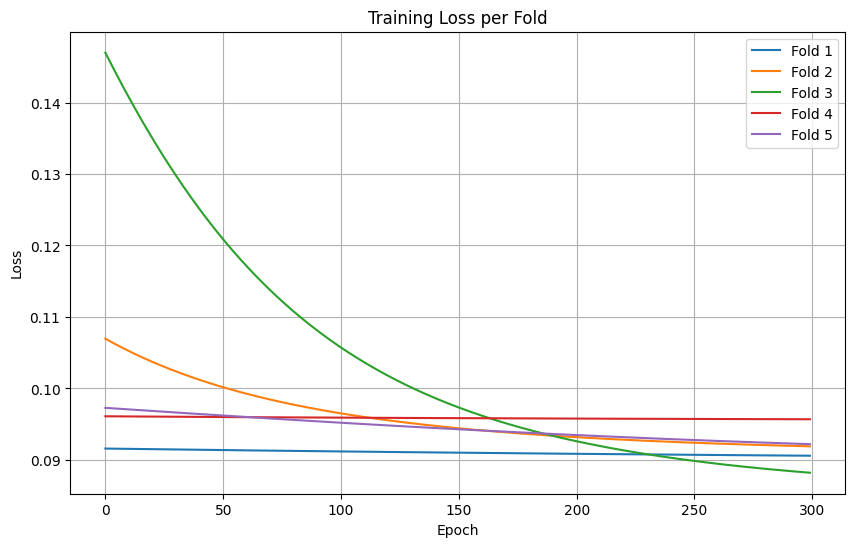

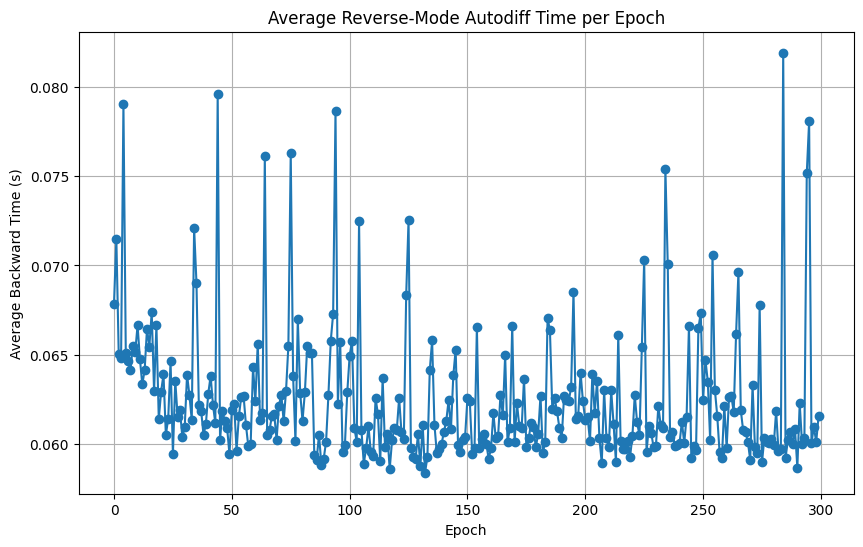

In [57]:
def load_txt_dataset(filepath, normalize=True):
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        data = [[float(val.strip()) for val in row] for row in reader]

    X = [row[:-1] for row in data]
    Y = [[row[-1]] for row in data]  # Empaquetado como lista para compatibilidad

    if normalize:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

    return X, Y

X_class, Y_class = load_txt_dataset("T_Blood_Transfusion.txt")
fold_losses_reverse_ex1, avg_backward_times_ex1 = train_kfold_reverse(X_class, Y_class, K=len(X_class[0]), L=4, J=len(Y_class[0]), epochs=300, lr=0.1, n_splits=5, is_classification=True)
    
plt.figure(figsize=(10, 6))
for i, losses in enumerate(fold_losses_reverse_ex1):
    plt.plot(losses, label=f"Fold {i + 1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Fold")
plt.legend()
plt.grid(True)
plt.show()

# Plot average backward time per epoch
plt.figure(figsize=(10, 6))
plt.plot(avg_backward_times_ex1, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Backward Time (s)")
plt.title("Average Reverse-Mode Autodiff Time per Epoch")
plt.grid(True)
plt.show()

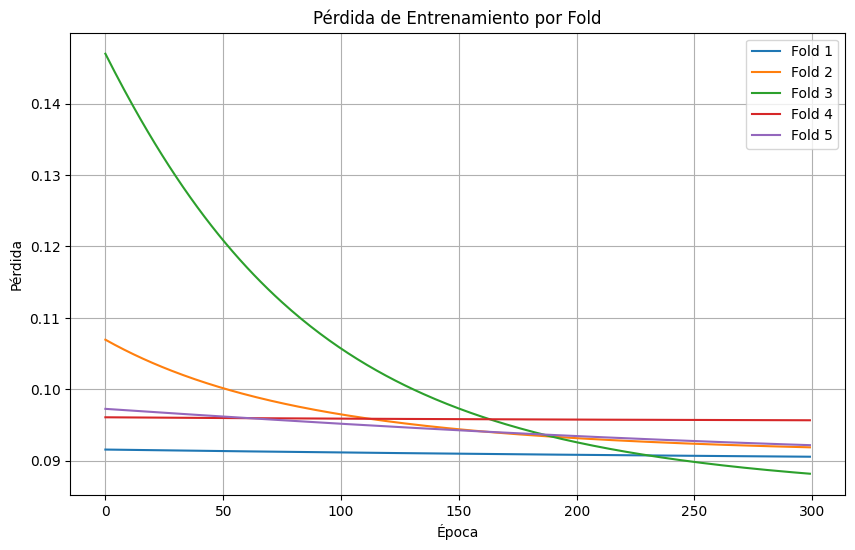

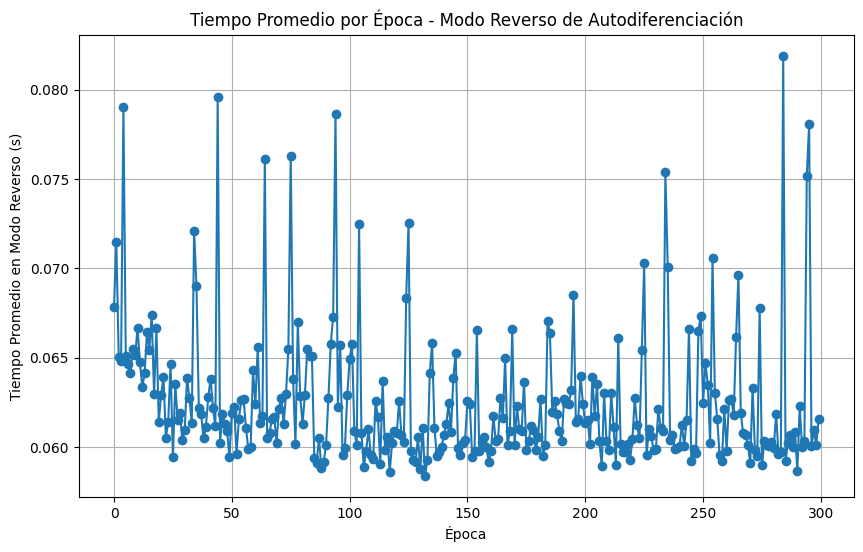

In [74]:
plt.figure(figsize=(10, 6))
for i, perdidas in enumerate(fold_losses_reverse_ex1):
    plt.plot(perdidas, label=f"Fold {i + 1}")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida de Entrenamiento por Fold")
plt.legend()
plt.grid(True)
plt.savefig("reverse_example4_11.pdf", format='pdf')
plt.show()

# Gráfico del tiempo promedio por época (modo reverso)
plt.figure(figsize=(10, 6))
plt.plot(avg_backward_times_ex1, marker='o')
plt.xlabel("Época")
plt.ylabel("Tiempo Promedio en Modo Reverso (s)")
plt.title("Tiempo Promedio por Época - Modo Reverso de Autodiferenciación")
plt.grid(True)
plt.savefig("reverse_example4_12.pdf", format='pdf')
plt.show()


### Breast Cancer Wisconsin Experiment
This experiment uses the Breast Cancer Wisconsin dataset with 30 numeric features extracted from cell nuclei images, such as radius, texture, perimeter, and others. Our goal is to classify tumors as malignant or benign (binary classification).

The model input layer has 30 nodes corresponding to the features, followed by a hidden layer (as defined), and one output node for the diagnosis (1 = malignant, 0 = benign).


--- Fold 1 ---
Epoch 0, Loss: 0.1427, Backward Time: 0.723646s
Epoch 10, Loss: 0.1327, Backward Time: 0.719703s
Epoch 20, Loss: 0.1207, Backward Time: 0.730588s
Epoch 30, Loss: 0.1076, Backward Time: 0.890295s
Epoch 40, Loss: 0.0955, Backward Time: 0.760557s
Epoch 50, Loss: 0.0861, Backward Time: 0.739168s
Epoch 60, Loss: 0.0800, Backward Time: 0.747730s
Epoch 70, Loss: 0.0763, Backward Time: 0.728320s
Epoch 80, Loss: 0.0741, Backward Time: 0.723815s
Epoch 90, Loss: 0.0727, Backward Time: 0.735442s
Validation Accuracy: 0.8333

--- Fold 2 ---
Epoch 0, Loss: 0.2217, Backward Time: 0.757575s
Epoch 10, Loss: 0.2074, Backward Time: 0.733006s
Epoch 20, Loss: 0.1932, Backward Time: 0.764882s
Epoch 30, Loss: 0.1805, Backward Time: 0.745835s
Epoch 40, Loss: 0.1702, Backward Time: 0.730246s
Epoch 50, Loss: 0.1623, Backward Time: 0.735132s
Epoch 60, Loss: 0.1563, Backward Time: 0.765353s
Epoch 70, Loss: 0.1517, Backward Time: 0.758519s
Epoch 80, Loss: 0.1481, Backward Time: 0.737489s
Epoch 90, L

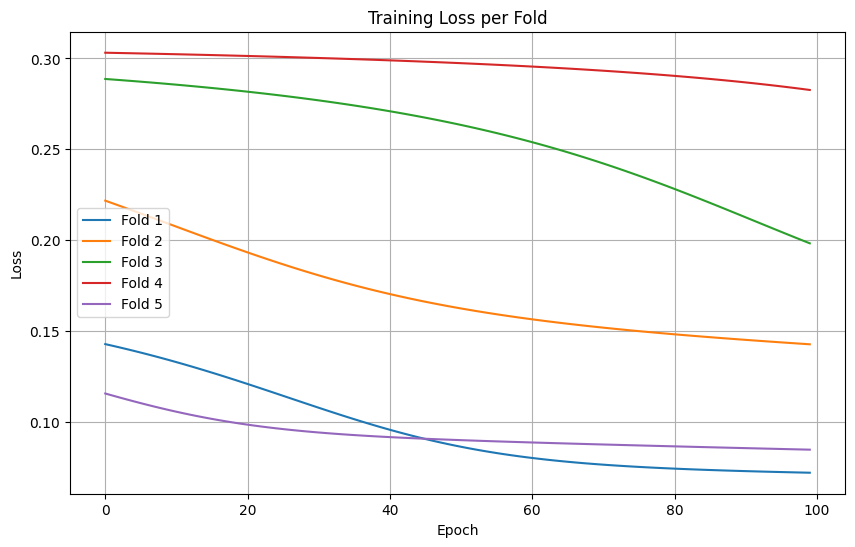

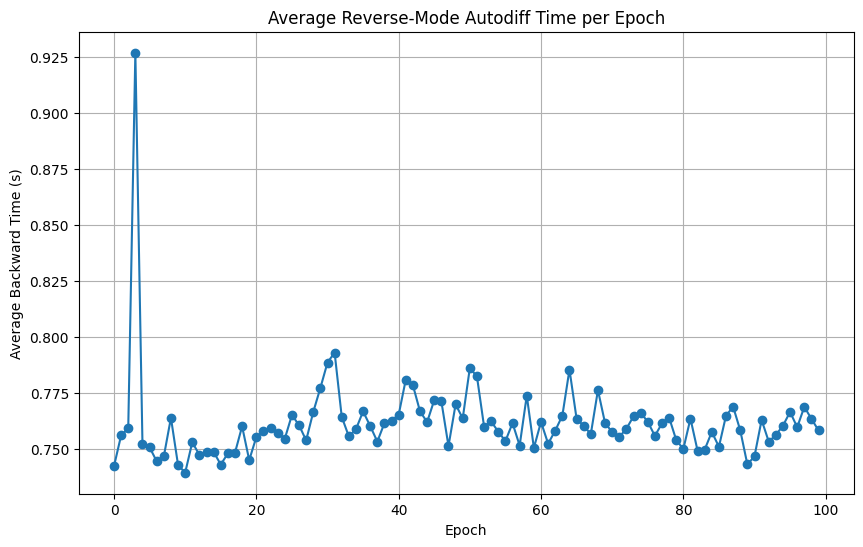

In [4]:
def load_breast_cancer_csv(path):
    X = []
    Y = []

    with open(path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            # Diagnosis is in column 1, features from column 2 onwards
            diagnosis = row[1]
            y = [1.0 if diagnosis == 'B' else 0.0]
            x = list(map(float, row[2:]))  # Skip id and diagnosis
            X.append(x)
            Y.append(y)

    # Normalize X using MinMax scaling
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X).tolist()

    return X, Y

X_data, Y_data = load_breast_cancer_csv("breast_cancer_data.csv")
fold_losses_reverse_ex2, avg_backward_times_ex2 = train_kfold_reverse(X_data, Y_data, K=len(X_data[0]), L=20, J=len(Y_data[0]), epochs=100, lr=0.1, n_splits=5, is_classification=True)

plt.figure(figsize=(10, 6))
for i, losses in enumerate(fold_losses_reverse_ex2):
    plt.plot(losses, label=f"Fold {i + 1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Fold")
plt.legend()
plt.grid(True)
plt.show()

# Plot average backward time per epoch
plt.figure(figsize=(10, 6))
plt.plot(avg_backward_times_ex2, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Backward Time (s)")
plt.title("Average Reverse-Mode Autodiff Time per Epoch")
plt.grid(True)
plt.show()

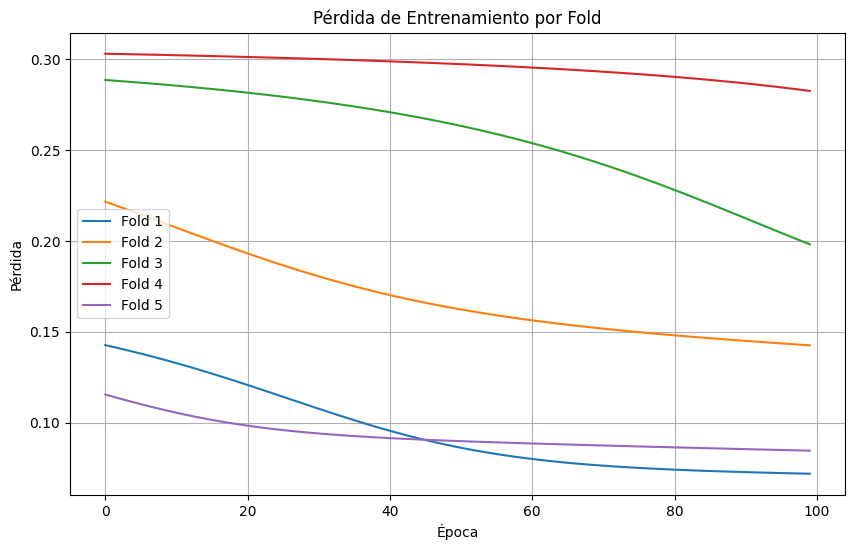

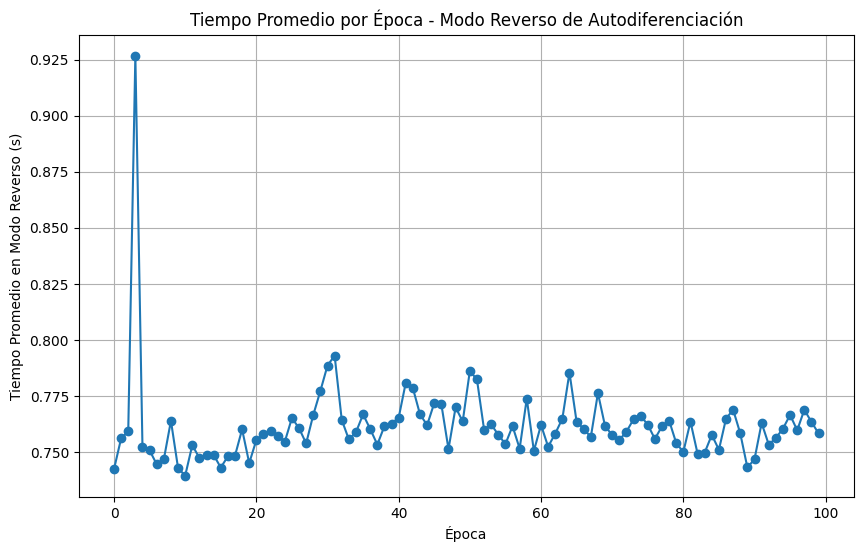

In [5]:
plt.figure(figsize=(10, 6))
for i, perdidas in enumerate(fold_losses_reverse_ex2):
    plt.plot(perdidas, label=f"Fold {i + 1}")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida de Entrenamiento por Fold")
plt.legend()
plt.grid(True)
plt.savefig("reverse_example4_21.pdf", format='pdf')
plt.show()

# Gráfico del tiempo promedio por época (modo reverso)
plt.figure(figsize=(10, 6))
plt.plot(avg_backward_times_ex2, marker='o')
plt.xlabel("Época")
plt.ylabel("Tiempo Promedio en Modo Reverso (s)")
plt.title("Tiempo Promedio por Época - Modo Reverso de Autodiferenciación")
plt.grid(True)
plt.savefig("reverse_example4_22.pdf", format='pdf')
plt.show()


# Forward Mode vs Reverse Mode

## Example 3: Comparing Forward and Reverse Mode on Vector Function Jacobians

In this section, we benchmark and directly compare the performance of **forward-mode** and **reverse-mode** automatic differentiation when computing the **full Jacobian** of a simple vector function.

---

## Benchmark Setup

We consider a simple vector-valued function:

$$
f: \mathbb{R}^n \to \mathbb{R}^m
$$

where each output component is given by:

$$
f(x)_j = \sum_{i=0}^{n-1} (j+1) \cdot x_i \quad \text{for} \quad j = 0, 1, \dots, m-1
$$

The Jacobian of $f$ is an $m \times n$ matrix, where each entry represents $\frac{\partial f_j}{\partial x_i}$.

We benchmark three scenarios:

- **Varying the number of inputs** $n$ while keeping outputs $m$ fixed
- **Varying the number of outputs** $m$ while keeping inputs $n$ fixed
- **Square case** where $n = m$

For each setting, we measure:

- **Time to compute the full Jacobian matrix**
- **How performance scales** with problem size

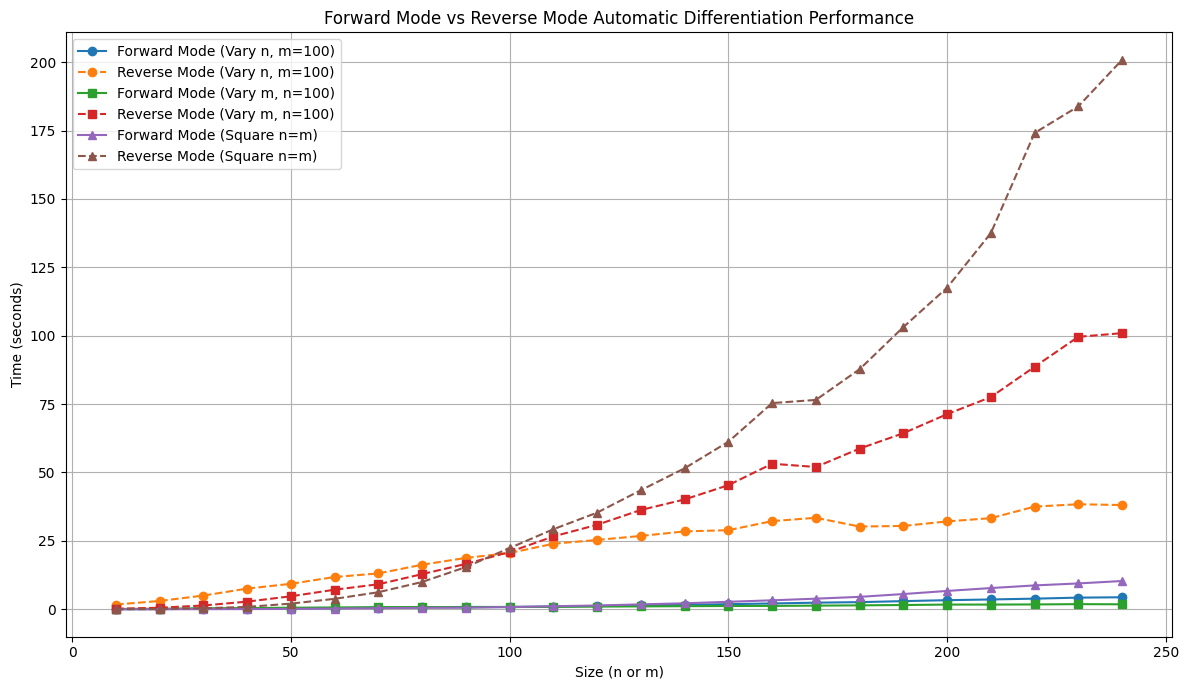

In [21]:
# Forward-mode vs Reverse-mode

plt.figure(figsize=(12, 7))

# Vary n (fix m)
plt.plot(sizes, times_vary_n_forward, label="Forward Mode (Vary n, m=100)", marker='o', linestyle='-')
plt.plot(sizes, times_vary_n_reverse, label="Reverse Mode (Vary n, m=100)", marker='o', linestyle='--')

# Vary m (fix n)
plt.plot(sizes, times_vary_m_forward, label="Forward Mode (Vary m, n=100)", marker='s', linestyle='-')
plt.plot(sizes, times_vary_m_reverse, label="Reverse Mode (Vary m, n=100)", marker='s', linestyle='--')

# Square case (n = m)
plt.plot(sizes, times_square_forward, label="Forward Mode (Square n=m)", marker='^', linestyle='-')
plt.plot(sizes, times_square_reverse, label="Reverse Mode (Square n=m)", marker='^', linestyle='--')

plt.title("Forward Mode vs Reverse Mode Automatic Differentiation Performance")
plt.xlabel("Size (n or m)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

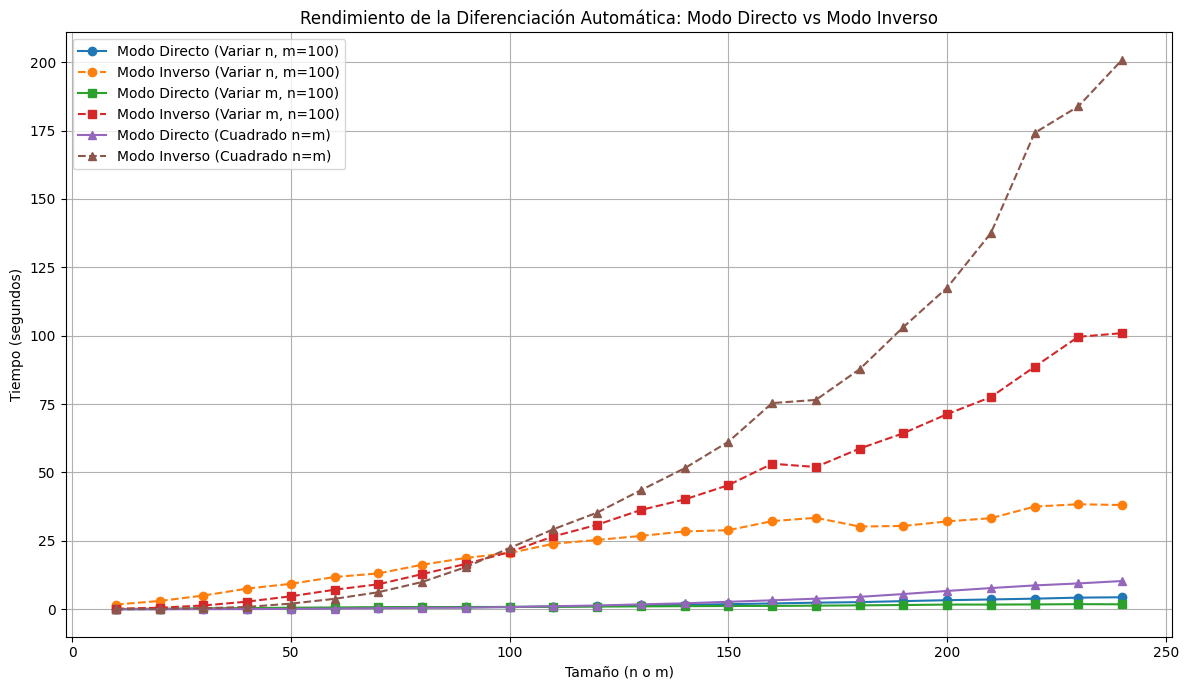

In [22]:
# Modo directo vs Modo inverso

plt.figure(figsize=(12, 7))

# Variar n (fijar m)
plt.plot(sizes, times_vary_n_forward, label="Modo Directo (Variar n, m=100)", marker='o', linestyle='-')
plt.plot(sizes, times_vary_n_reverse, label="Modo Inverso (Variar n, m=100)", marker='o', linestyle='--')

# Variar m (fijar n)
plt.plot(sizes, times_vary_m_forward, label="Modo Directo (Variar m, n=100)", marker='s', linestyle='-')
plt.plot(sizes, times_vary_m_reverse, label="Modo Inverso (Variar m, n=100)", marker='s', linestyle='--')

# Caso cuadrado (n = m)
plt.plot(sizes, times_square_forward, label="Modo Directo (Cuadrado n=m)", marker='^', linestyle='-')
plt.plot(sizes, times_square_reverse, label="Modo Inverso (Cuadrado n=m)", marker='^', linestyle='--')

plt.title("Rendimiento de la Diferenciación Automática: Modo Directo vs Modo Inverso")
plt.xlabel("Tamaño (n o m)")
plt.ylabel("Tiempo (segundos)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forward_reverse_comparison1.pdf", format='pdf')
plt.show()


## Results

We plot the computation time for both **forward-mode** and **reverse-mode** automatic differentiation on the same graphs for direct visual comparison.

- In **forward-mode**, each input direction is processed separately.
- In **reverse-mode**, each output is backpropagated separately.

---

## Observations

- Forward-mode is particularly efficient because it computes derivatives with respect to each input independently.
- Reverse-mode would be more advantageous if the number of **outputs** ($m$) were much smaller than the number of inputs, but here each output depends similarly on all inputs, and the overhead of reverse-mode accumulates.
- In the **square case** ($n = m$), forward-mode still remains faster at moderate sizes.



## Example 4.2: Comparing Forward and Reverse Mode on Multilayer Perceptron Loss Function

In this section, we compare the efficiency of automatic differentiation modes—specifically, **forward-mode** and **reverse-mode**—when computing gradients of the loss function in a multilayer perceptron (MLP).

---

## Benchmark Setup

We use the same MLP architecture and the dataset used is the Breast Cancer Wisconsin Experiment, described earlier. The network is fully connected with differentiable activations and a scalar loss computed via **mean squared error** over the dataset.

To evaluate performance, we measure the **total computation time** for its full gradient with respect to all weights  

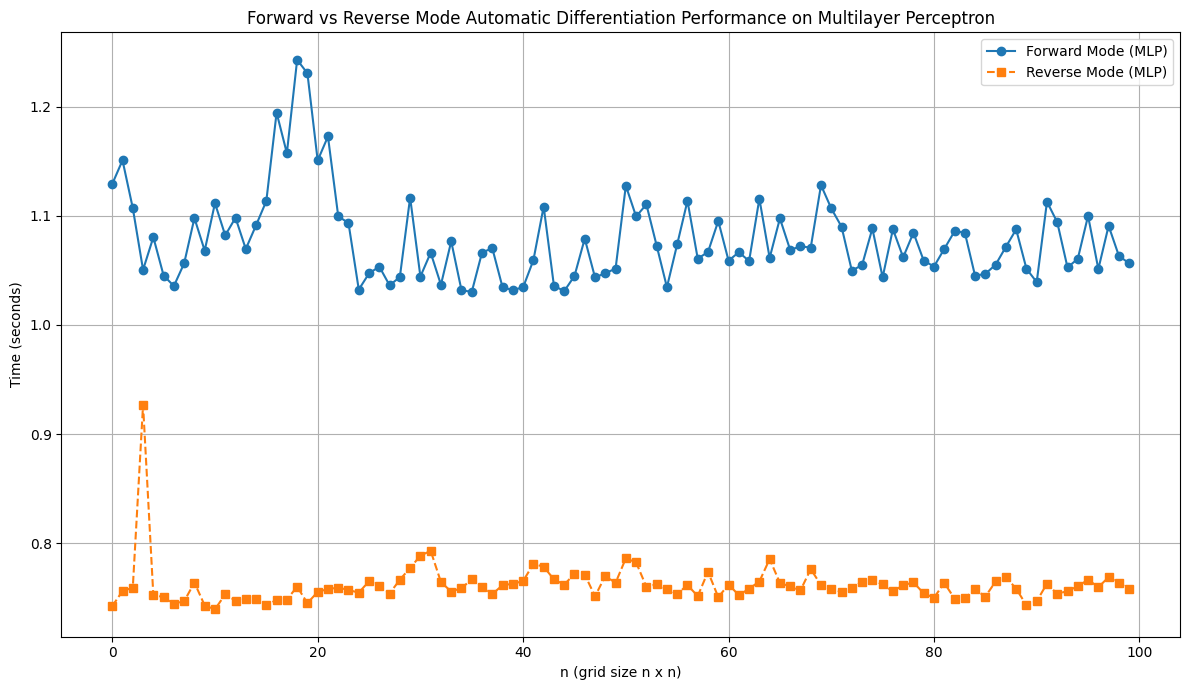

In [ ]:
# Forward-mode vs Reverse-mode on Multilayer Perceptron
plt.figure(figsize=(12, 7))

# Plotting
plt.plot(avg_forward_times_ex2, label="Forward Mode (MLP)", marker='o', linestyle='-')
plt.plot(avg_backward_times_ex2, label="Reverse Mode (MLP)", marker='s', linestyle='--')

plt.title("Forward vs Reverse Mode Automatic Differentiation Performance on Multilayer Perceptron")
plt.xlabel("n (grid size n x n)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

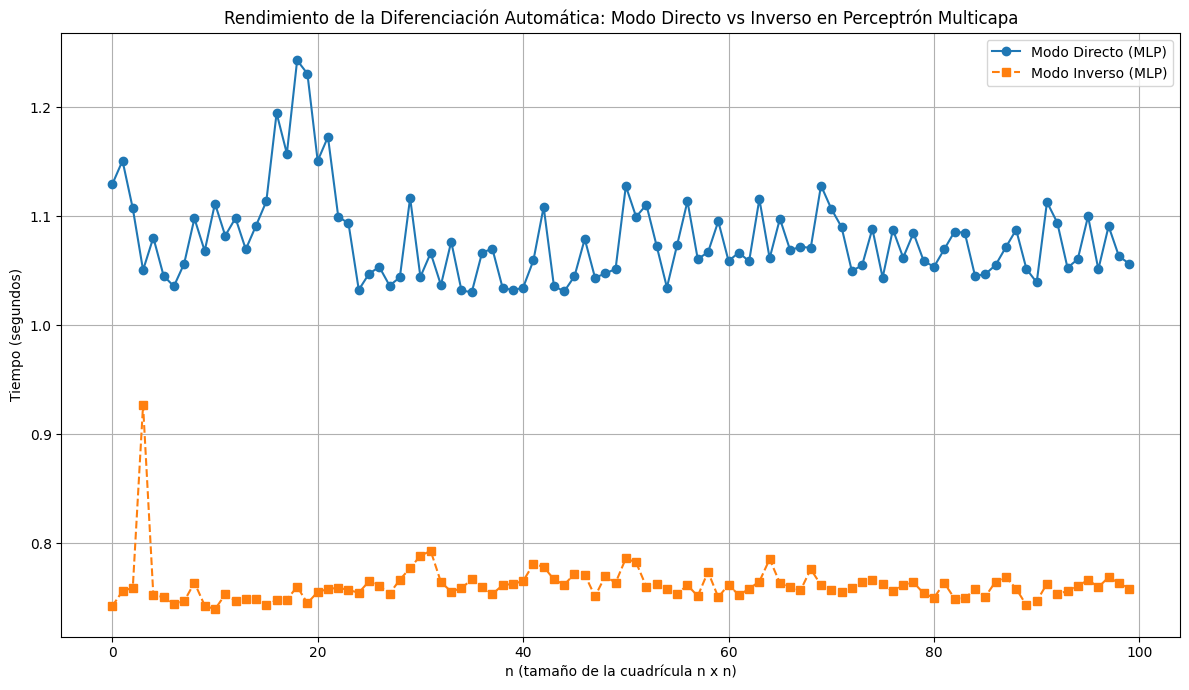

In [14]:
# Modo directo vs Modo inverso en perceptrón multicapa

plt.figure(figsize=(12, 7))

# Gráficas
plt.plot(avg_forward_times_ex2, label="Modo Directo (MLP)", marker='o', linestyle='-')
plt.plot(avg_backward_times_ex2, label="Modo Inverso (MLP)", marker='s', linestyle='--')

plt.title("Rendimiento de la Diferenciación Automática: Modo Directo vs Inverso en Perceptrón Multicapa")
plt.xlabel("n (tamaño de la cuadrícula n x n)")
plt.ylabel("Tiempo (segundos)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forward_reverse_mlp_2.pdf", format='pdf')
plt.show()


## Results

We plot the time taken by **forward-mode** and **reverse-mode** on the same graph for direct comparison.

- **Forward-mode** gradient computation times are consistently higher (typically >1.0 units)  
- **Reverse-mode** times are notably faster (~0.6 to 0.7 units)

This result aligns with the theoretical strengths of reverse-mode autodiff: it is well-suited for functions with many inputs and a single scalar output—such as neural network loss functions. Since forward-mode computes directional derivatives one input at a time, its cost scales with the number of parameters. In contrast, reverse-mode traverses the computational graph once, regardless of the input dimensionality, making it significantly more efficient for large-scale gradient evaluations in training neural networks.